In [1]:
import sys, os
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('../modules')
from nsw.nsw_classifier import NSWClassifier
import nsw.data_gen as dg

In [56]:
import time

def analyze_classifier(classifer, test, label, iterations=7):
    path_times, knn_times = [], []
    path, knn = 0, 0
    times = iterations

    for i in range(times):
        print(f"iteration {i}")
        s = time.perf_counter()
        for t in test:
            path += classifier.classify_by_path(t[0], attempts=1) == t[1]
        f = time.perf_counter()
        path_times.append(f - s)

        s = time.perf_counter()
        for t in test:
            knn += classifier.classify_knn(t[0], attempts=1) == t[1]
        f = time.perf_counter()
        knn_times.append(f - s)


    print(f"{label}: NEW PATH classifier accuracy = {100 * path / len(test) / times:.2f}%")
    print(f"{label}: KNN classifier accuracy = {100 * knn / len(test) / times:.2f}%")

    plt.plot(path_times, label="PATH")
    plt.plot(knn_times, label="KNN(1)")
    plt.legend()
    plt.show()


    speedup = [a / b for a, b in zip(knn_times, path_times)]
    plt.plot(speedup, label="speedup (times)")
    plt.legend()
    plt.show()

    print(f"Speedup: Min = {min(speedup):.2f}, Max = {max(speedup):.2f}, Avg = {sum(speedup) / len(speedup):.2f}")

# 1. Synthetic dataset - proof of concept

Classifier graph is build in 11.061s


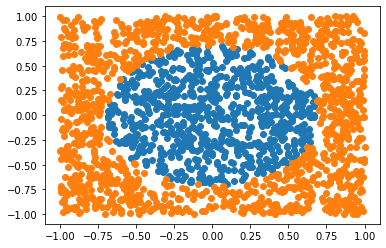

In [54]:
classifier = NSWClassifier()
data = dg.gen(N=2000, border=0.7)
classifier.build_navigable_graph(data, attempts=20)

# show classes
cls0 = np.array([r[0] for r in data if r[1] == 0])
cls1 = np.array([r[0] for r in data if r[1] == 1])
plt.scatter(cls0[:,0], cls0[:,1])
plt.scatter(cls1[:,0], cls1[:,1])
plt.show()

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
Synth: NEW PATH classifier accuracy = 94.79%
Synth: KNN classifier accuracy = 99.00%


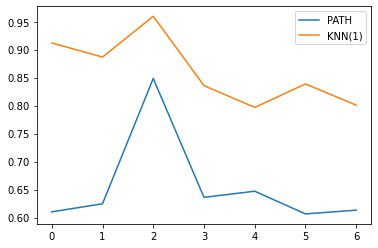

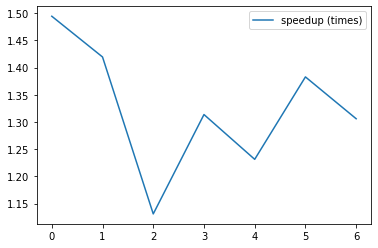

Speedup: Min = 1.13, Max = 1.49, Avg = 1.33


In [57]:
test = dg.gen(N=200, border=0.7)
    
analyze_classifier(classifier, test, "Synth")

# 2. Simple case: MINST

```
@ARTICLE{155943,
  author={L. {Xu} and A. {Krzyzak} and C. Y. {Suen}},
  journal={IEEE Transactions on Systems, Man, and Cybernetics}, 
  title={Methods of combining multiple classifiers and their applications to handwriting recognition}, 
  year={1992},
  volume={22},
  number={3},
  pages={418-435},}
```

In [4]:
!python -m pip install mnist

In [25]:
from sklearn import datasets
import random

digits = datasets.load_digits()
X, Y = [x.flatten() for x in digits.images], digits.target
XY = list(zip(X, Y))
random.shuffle(XY)
train, test = XY[:9 * len(XY) // 10], XY[9 * len(XY) // 10:]

minst_classifier = NSWClassifier()
minst_classifier.build_navigable_graph(train, attempts=20)

Classifier graph is build in 80.726s


iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
MNIST: NEW PATH classifier accuracy = 97.57%
MNIST: KNN classifier accuracy = 98.00%


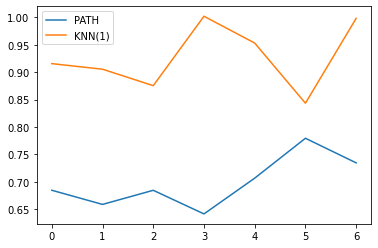

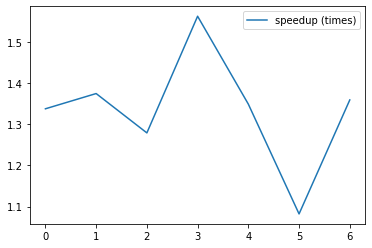

Speedup: Min = 1.08, Max = 1.56, Avg = 1.33


In [34]:
import time

analyze_classifier(minst_classifier, test, 'MNIST')

# 100 leaves

[dataset](https://archive.ics.uci.edu/ml/datasets/One-hundred+plant+species+leaves+data+set)

```
@inproceedings{Mallah2013PLANTLC,
  title={PLANT LEAF CLASSIFICATION USING PROBABILISTIC INTEGRATION OF SHAPE, TEXTURE AND MARGIN FEATURES},
  author={Charles D. Mallah and James S. Cope and James Orwell},
  year={2013}
}
```

In [58]:
import random

texture_file = "../data/100leaves/data_Tex_64.txt"
shape_file = "../data/100leaves/data_Sha_64.txt"
margin_file = "../data/100leaves/data_Mar_64.txt"

dataset = []
for line in open(shape_file):
    parts = line.strip().split(',')
    class_, vect = parts[0], list(map(float, parts[1:]))
    dataset.append((vect, class_))

random.shuffle(dataset)

train, test = dataset[:9 * len(dataset) // 10], dataset[9 * len(dataset) // 10:]
print(f"train {len(train)}; test {len(test)}")

train 1440; test 160


In [61]:
leaves_classifier = NSWClassifier()
leaves_classifier.build_navigable_graph(train[:100], attempts=10)

Classifier graph is build in 0.834s


In [62]:
analyze_classifier(leaves_classifier, test, "100LEAVES")

iteration 0


ValueError: operands could not be broadcast together with shapes (64,) (2,) 